# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Import Statements

In [160]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

print('...')

...


### Load Training Data

In [157]:
car_images = glob.glob('training_dataset/vehicles/**/*.png')
noncar_images = glob.glob('training_dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


### Visualize Some of the Data

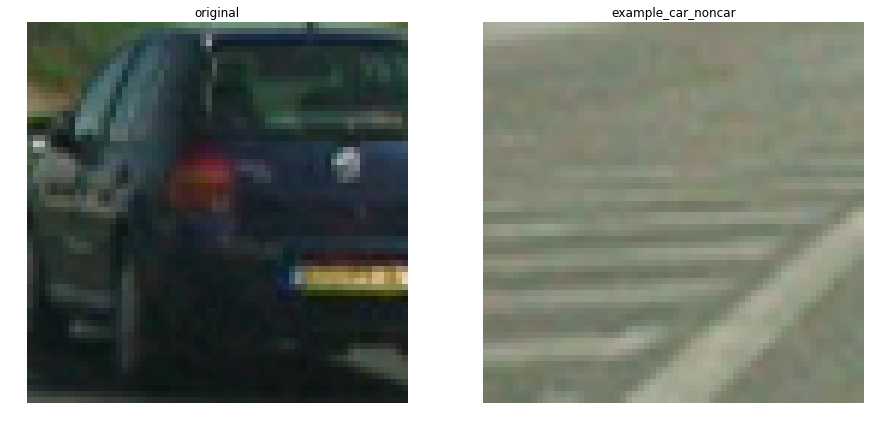

In [163]:
# define function to show image and save to file
def showImages(images, imagesName, figTitle= None, cols = 4, rows = 5, figsize=(15,10), cmap = None, figName = None):
    """
        Display `images` on a [`cols`, `rows`] subplot grid.
        """
    if len(images) != len(imagesName):
        raise ValueError('Lenth of images and imagesName are not same')
    
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    plt.suptitle(figTitle)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName = imagesName[index],
            image = images[index]
            ax.imshow(image,cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')

    if figName != None:
        print("save fig name: ", figName)
        saveName = "./output_images/" + figName + ".png"
        fig.savefig(saveName)

    plt.show()

# define function to show Side by Side and save to file
def showSidebySide(original, new, firstTitle ="original", newTitle = "new"):
    figsize=(15, 10)
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    axes[0].imshow(original)
    axes[0].set_title(firstTitle)
    axes[1].imshow(new)
    axes[1].set_title(newTitle)
    axes[0].axis('off')
    axes[1].axis('off')

    ## save figure
    saveName = "./output_images/" + newTitle + ".png"
    fig.savefig(saveName)
    plt.show()
    
def showImagesSidebySide(original, new, firstTitle ="original", newTitle = "new", imagesName=None,cmap = None):
    figsize=(20, 20)
    imgLength = len(original)
    fig, axes = plt.subplots(nrows=imgLength, ncols=2, figsize=figsize)
    axes1 = axes[:,0]
    axes2 = axes[:,1]
    for ax1, ax2, index in zip(axes1, axes2, range(imgLength)):
        if imagesName != None:
            imagePathName = imagesName[index]
            ax1.set_title(imagePathName)
        else:
            ax1.set_title(firstTitle)
        ax2.set_title(newTitle)
        orgimg = original[index]
        newimg = new[index]
        ax1.imshow(orgimg)
        ax2.imshow(newimg,cmap=cmap)
        ax1.axis('off')
        ax2.axis('off')
    ## save figure
    saveName = "./output_images/" + newTitle + ".png"
    fig.savefig(saveName)
    plt.show()
    
car_img = mpimg.imread(car_images[10])
noncar_img = mpimg.imread(noncar_images[10])
showSidebySide(car_img, noncar_img, newTitle='example_car_noncar')

img size: , name size:  64 64
save fig name:  Random_Car_NonCar


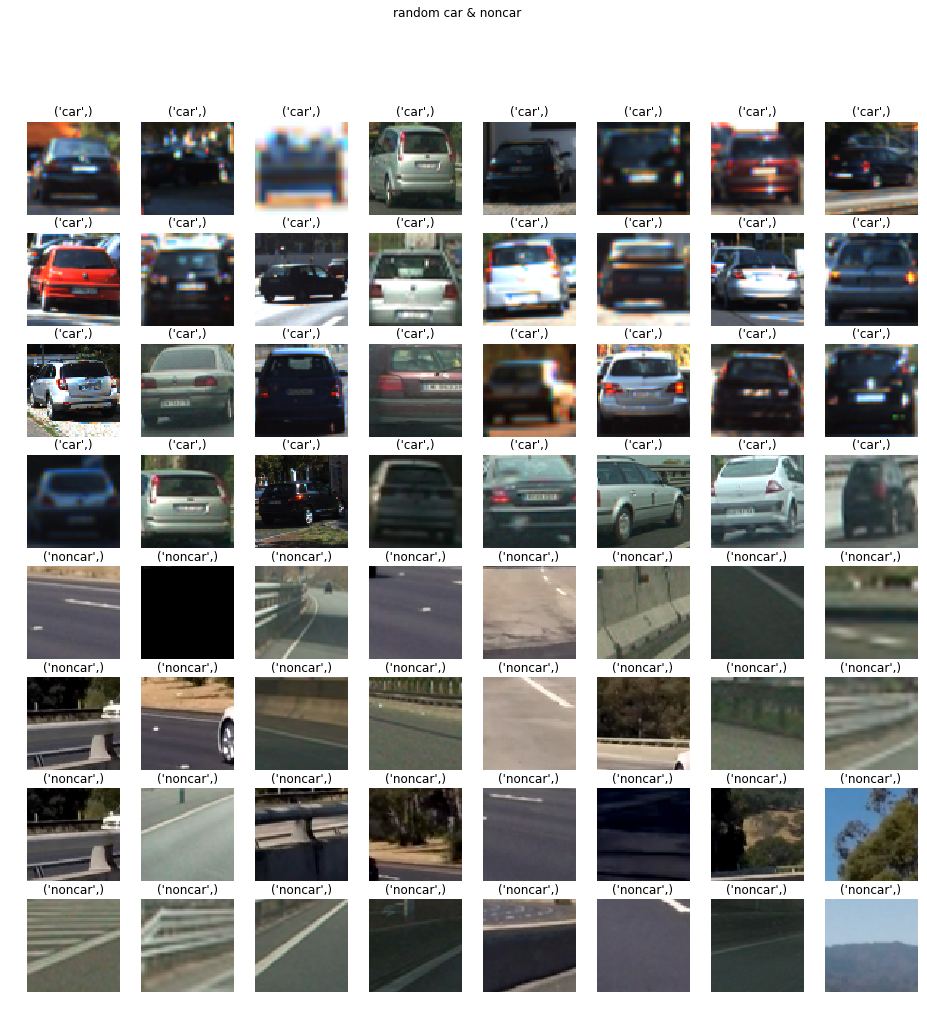

In [164]:
#fig, axs = plt.subplots(8,8, figsize=(16, 16))
#fig.subplots_adjust(hspace = .2, wspace=.001)
#axs = axs.ravel()

imgs = []
imgsName = []
# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    imgs.append(img)
    imgsName.append("car")    
for i in np.arange(32):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    imgs.append(img)
    imgsName.append("noncar")
print("img size: , name size: ", len(imgs), len(imgsName))
showImages(imgs, imgsName,figTitle='random car & noncar', cols=8,rows=8,
              figsize=(16, 16), figName = "Random_Car_NonCar")

# Define Method to Convert Image to Histogram of Oriented Gradients (HOG)
*This method was duplicated from lesson materials*

In [165]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('...')

...


### Visualize HOG on example image

In [166]:
# get the HOG images to show the parameter effect
def get_hog_images(img, orient, pix_per_cell, cell_per_block, imgName):
    features, hog_image = hog(img, orientations=orient, 
                          pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, 
                          visualise=True, feature_vector=True)
    newImageName = imgName +"_ORT" + str(orient) + '_PIX' + str(pix_per_cell)+ "_CEL" + str(cell_per_block)
    showSidebySide(img, hog_image, imgName, newImageName)

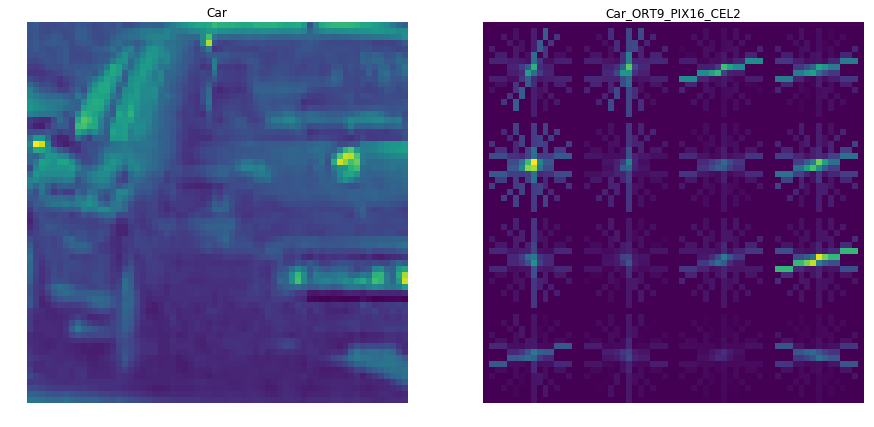

In [167]:
car_img = mpimg.imread(car_images[10])
w = interact_manual(get_hog_images, orient=(5,12), pix_per_cell=(4,16), 
                    cell_per_block=(1,5), img=fixed(car_img[:,:,2]), imgName=fixed('Car'));
print(w)

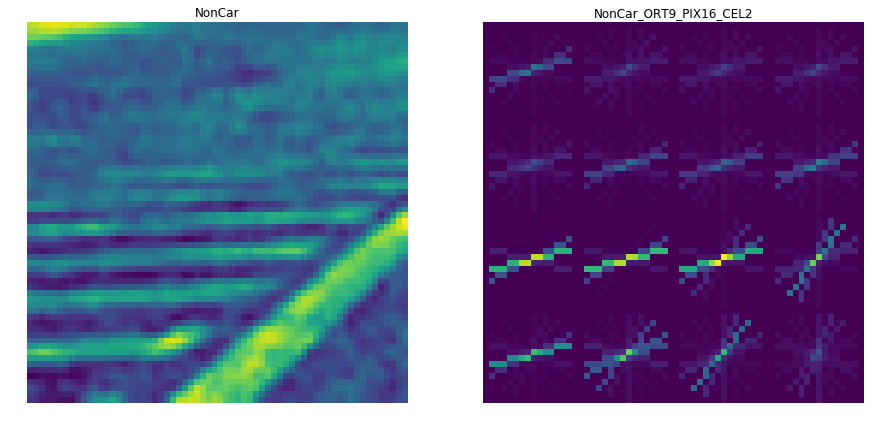

In [168]:
noncar_img = mpimg.imread(noncar_images[10])
w = interact_manual(get_hog_images, orient=(5,12), pix_per_cell=(4,16), 
                    cell_per_block=(1,5), img=fixed(noncar_img[:,:,2]), imgName=fixed('NonCar'));
print(w)

### Method to Extract HOG Features from an Array of Car and Non-Car Images
*The code for this method was mostly duplicated from course lesson material.*

In [169]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)

        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    #print("features:", features)
    return features

print('...')


...


### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

In [170]:
# save test result in excel file
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
#import StringIO

def saveExcel(rawdata, columns, filename):
    #output = io.BytesIO()
    df = pd.DataFrame(rawdata, columns = columns)
    #writer = ExcelWriter(filename)
    #writer = ExcelWriter(filename, engine='xlsxwriter')
    #df.to_csv(writer,'Sheet1',index=False)
    df.to_csv(filename, sep=',')
    #writer.save()

columns = ['Colorspace', 'Orientations', 'Pixels Per Cell',
           'Cells Per Block','HOG Channel','Feature extracted','Extract Time', 'Accuracy']
data = [[1,2,3,4,5,6,7,8],[1,3,5,6,7,8,9,10]]
saveExcel(data, columns,"testResult.csv")

In [50]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


colorSpaces = ['YUV','HLS', 'HSV','LUV', 'YCbCr']
#colorSpaces = ['YUV','RGB']
#hogChannels = [0,1,2,"ALL"]
hogChannels = [0,"ALL"]
datas = []
# Check the feature extraction speed and classifier accuracy
for colorspace in colorSpaces:
    for orient in range(7,12,2):
        for pix_per_cell in range(4,17,4):
            for cell_per_block in range(2,3):
                for hog_channel in hogChannels:
                    t = time.time()
                    car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel)
                    notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel)
                    t2 = time.time()
                    # Create an array stack of feature vectors
                    X = np.vstack((car_features, notcar_features)).astype(np.float64)
                    print("X shape:", X.shape)

                    # Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
                    #X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
                    #scaled_X = X_scaler.transform(X)

                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    print("Y shape: ", y.shape)


                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=rand_state)

                    feature_extracted = len(X_train[0])
                    print('Feature vector length:', feature_extracted)

                    # Use a linear SVC 
                    svc = LinearSVC()
                    svc.fit(X_train, y_train)
                    # Check the score of the SVC
                    accuracy = round(svc.score(X_test, y_test), 4)

                    data = [colorspace, orient, pix_per_cell, cell_per_block, hog_channel, 
                            feature_extracted, round(t2-t, 2), accuracy]
                    datas.append(data)

saveExcel(datas, columns,"testResult.csv")
print(...)

X shape: (17760, 6300)
Y shape:  (17760,)
Feature vector length: 6300
My SVC predicts:  [1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
X shape: (17760, 6300)
Y shape:  (17760,)
Feature vector length: 6300
My SVC predicts:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
For these 10 labels:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
X shape: (17760, 6300)
Y shape:  (17760,)
Feature vector length: 6300
My SVC predicts:  [0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
For these 10 labels:  [0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
X shape: (17760, 18900)
Y shape:  (17760,)
Feature vector length: 18900
My SVC predicts:  [0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
For these 10 labels:  [0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
X shape: (17760, 1372)
Y shape:  (17760,)
Feature vector length: 1372
My SVC predicts:  [1. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
For these 10 labels:  [1. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
X shape: (17760, 1372)
Y shape:  (17760,)
Feature vector length: 1372
My SVC predicts:  [1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
For thes

My SVC predicts:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
For these 10 labels:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
X shape: (17760, 6300)
Y shape:  (17760,)
Feature vector length: 6300
My SVC predicts:  [1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
For these 10 labels:  [1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
X shape: (17760, 6300)
Y shape:  (17760,)
Feature vector length: 6300
My SVC predicts:  [1. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
For these 10 labels:  [1. 0. 1. 1. 0. 0. 1. 0. 1. 1.]
X shape: (17760, 6300)
Y shape:  (17760,)
Feature vector length: 6300
My SVC predicts:  [1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
For these 10 labels:  [0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
X shape: (17760, 18900)
Y shape:  (17760,)
Feature vector length: 18900
My SVC predicts:  [0. 1. 0. 1. 1. 1. 0. 1. 1. 0.]
For these 10 labels:  [0. 1. 0. 0. 1. 1. 0. 1. 1. 0.]
X shape: (17760, 1372)
Y shape:  (17760,)
Feature vector length: 1372
My SVC predicts:  [1. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
For these 10 labels:  [1. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
X shape: (17760, 1372)
Y

X shape: (17760, 1188)
Y shape:  (17760,)
Feature vector length: 1188
My SVC predicts:  [1. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
For these 10 labels:  [1. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
Ellipsis


**Parameter exploration**

| Configuration Label | Colorspace | Orientations | Pixels Per Cell | Cells Per Block | HOG Channel | Extract Time |
| :-----------------: | :--------: | :----------: | :-------------: | :-------------: | :---------: | ------------:|
| 1                   | RGB        | 9            | 8               | 2               | ALL         | 71.16        |
| 2                   | HSV        | 9            | 8               | 2               | 1           | 43.74        |
| 3                   | HSV        | 9            | 8               | 2               | 2           | 36.35        |
| 4                   | LUV        | 9            | 8               | 2               | 0           | 37.42        |
| 5                   | LUV        | 9            | 8               | 2               | 1           | 38.34        |
| 6                   | HLS        | 9            | 8               | 2               | 0           | 37.42        |
| 7                   | HLS        | 9            | 8               | 2               | 1           | 42.04        |
| 8                   | YUV        | 9            | 8               | 2               | 0           | 35.86        |
| 9                   | YCrCb      | 9            | 8               | 2               | 1           | 38.32        |
| 10                  | YCrCb      | 9            | 8               | 2               | 2           | 38.99        |
| 11                  | HSV        | 9            | 8               | 2               | ALL         | 79.72        |
| 12                  | LUV        | 9            | 8               | 2               | ALL         | 78.57        |
| 13                  | HLS        | 9            | 8               | 2               | ALL         | 81.37        |
| 14                  | YUV        | 9            | 8               | 2               | ALL         | 81.82        |
| 15                  | YCrCb      | 9            | 8               | 2               | ALL         | 79.05        |
| 16                  | YUV        | 9            | 8               | 1               | 0           | 44.04        |
| 17                  | YUV        | 9            | 8               | 3               | 0           | 37.74        |
| 18                  | YUV        | 6            | 8               | 2               | 0           | 37.12        |
| 19                  | YUV        | 12           | 8               | 2               | 0           | 40.11        |
| 20                  | YUV        | 11           | 8               | 2               | 0           | 38.01        |
| 21                  | YUV        | 11           | 16              | 2               | 0           | 30.21        |
| 22                  | YUV        | 11           | 12              | 2               | 0           | 30.33        |
| 23                  | YUV        | 11           | 4               | 2               | 0           | 69.08        |
| 24                  | YUV        | 11           | 16              | 2               | ALL         | 55.20        |
| 25                  | YUV        | 7            | 16              | 2               | ALL         | 53.18        |


### Train a Classifier

In [171]:
## select the parameter
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

47.44 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


### Method for Using Classifier to Detect Cars in an Image
*This code is adapted from lesson material*

In [173]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            #print("hog_feat1 shape", hog_feat1.shape)
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #print("hog_feat2 shape", hog_feat2.shape)
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #print("hog feature shape: ", hog_features.shape)
            hog_features = hog_features.reshape(1, -1)
            #print("hog feature shape: ", hog_features.shape)            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('...')

...


### Test `Find_Cars` on an Example Image

In [174]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


### Method to Draw Rectangles onto an Image
*Duplicated from lesson material*

In [175]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


Draw the rectangles onto the example image

...


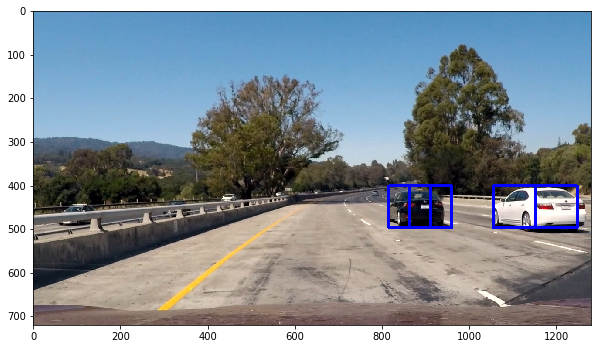

In [176]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

### Show All Potential Search Areas

Becuase the size and position of cars in the image will be different depending on their distance from the camera, `find_cars` will have to be called a few times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  78


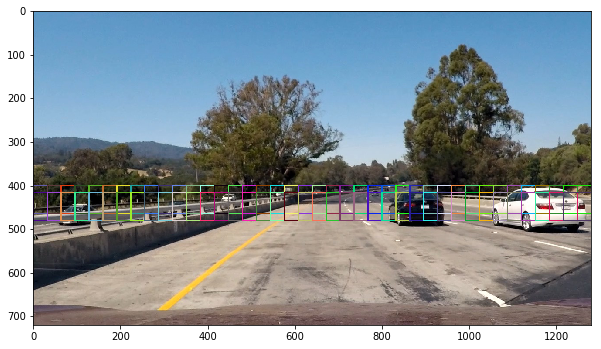

In [177]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  50


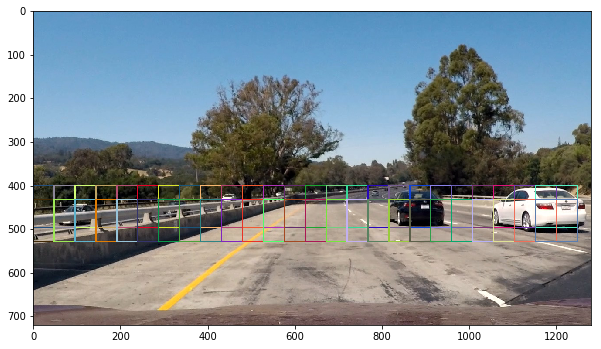

In [178]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


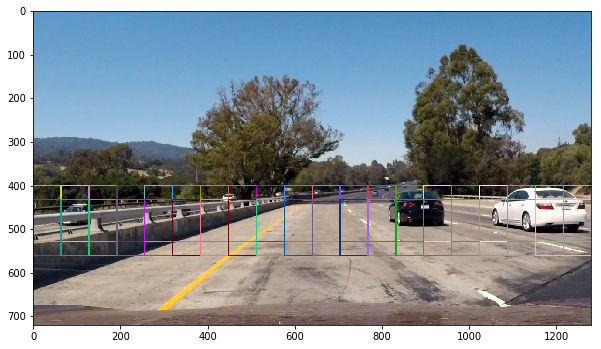

In [179]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


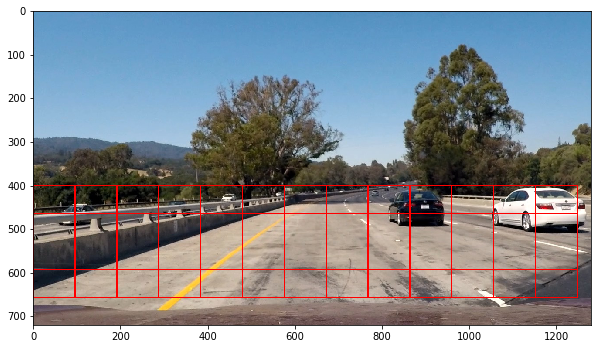

In [180]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color=(255,0,0), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Combine Various Sliding Window Searches

...


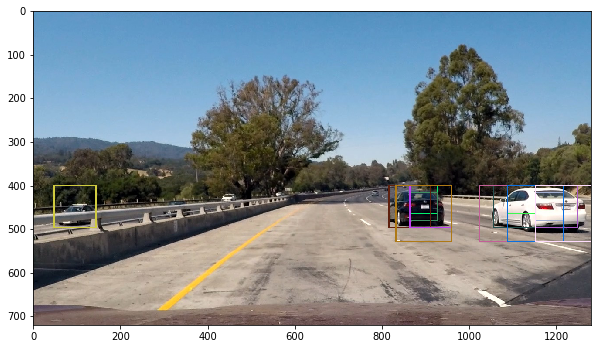

In [197]:
test_img = mpimg.imread('./test_images/test1.jpg')


colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

def detectInSlideWin(test_img, colorspace, orient, pix_per_cell, cell_per_block, hog_channel):    
    rectangles = []
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rectangles for item in sublist]
    return rectangles


rectangles = detectInSlideWin(test_img, colorspace, orient, 
                              pix_per_cell, cell_per_block, hog_channel)
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

*Exploration findings:* 
- A scale of less than 1.0 seemed to produce a lot of false positives. 
- The start and stop positions and scales used may need some tweaking in the future, depending on video performance.

### Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [182]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

...


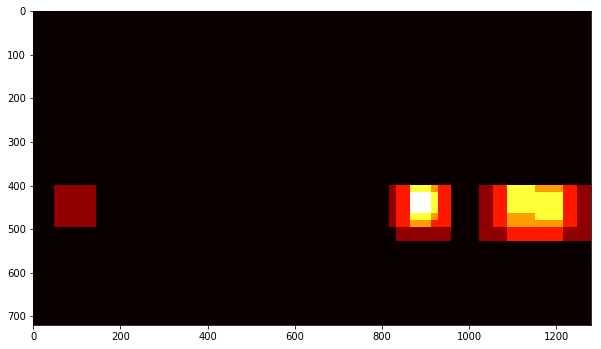

In [198]:
# Test out the heatmap
# Load test images.
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply a Threshold to the Heatmap

In [192]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    thremap = heatmap.copy()
    thremap[heatmap <= threshold] = 0
    # Return thresholded map
    return thremap


print('...')

...


...


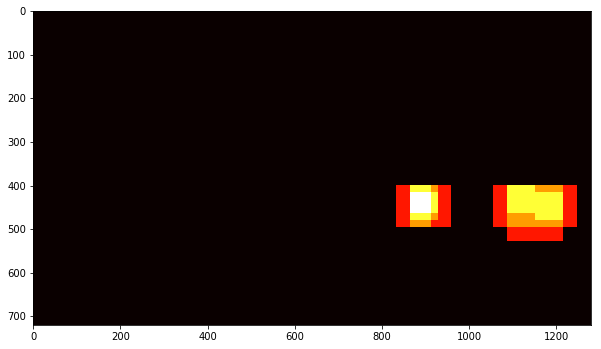

In [199]:
thremap = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(thremap, cmap='hot')
print('...')

### Apply SciPy Labels to Heatmap

2 cars found


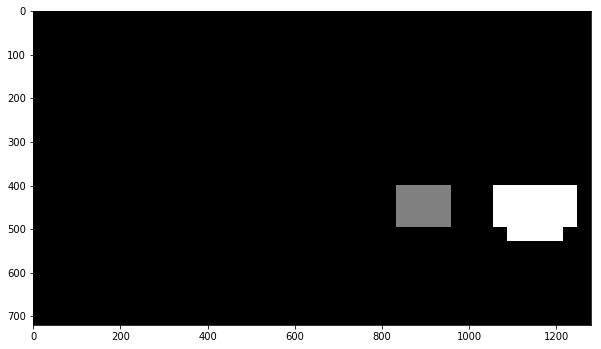

In [186]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

...


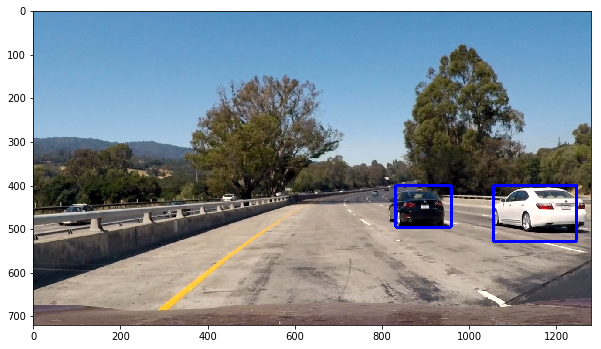

In [187]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

### Put it All Together

Run the pipeline on all the test images.

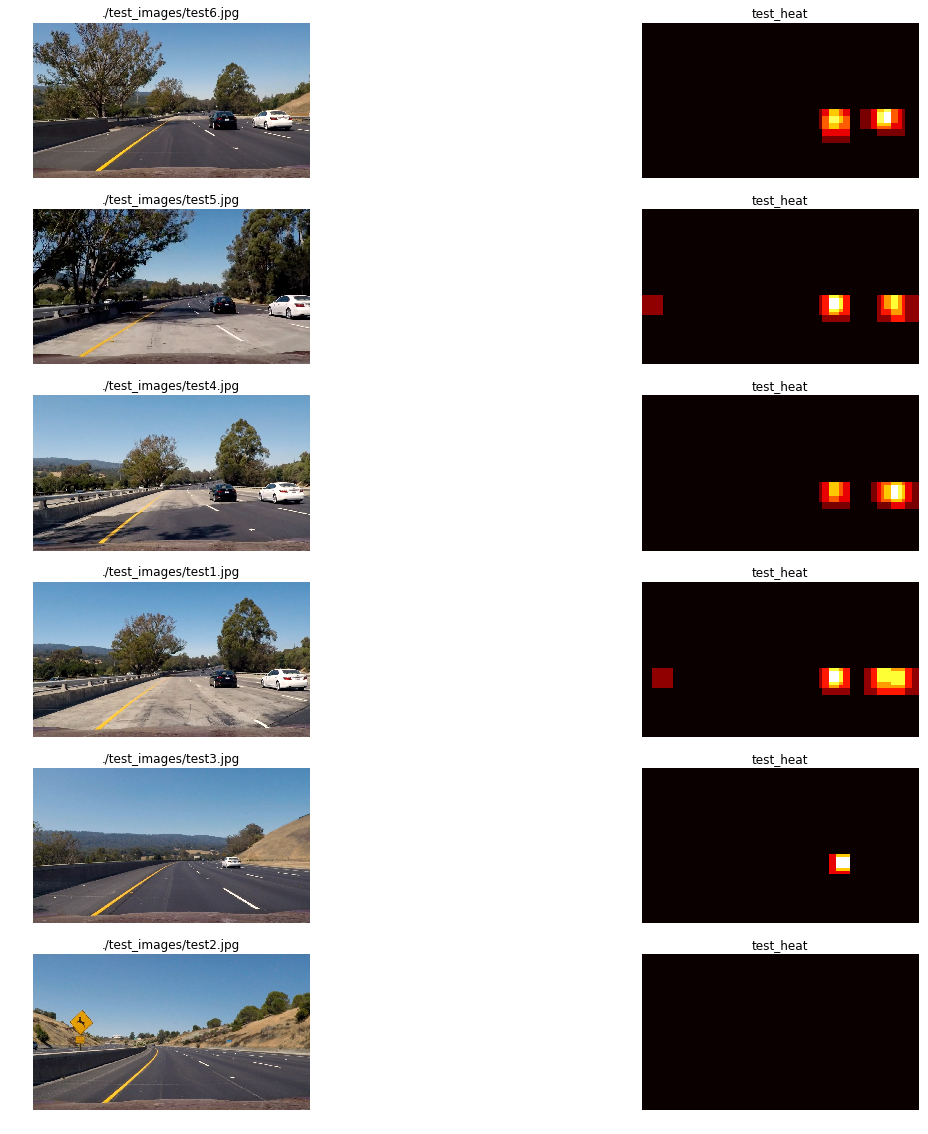

In [206]:
testImages = list(map(lambda imageFileName: mpimg.imread(imageFileName),
                      glob.glob('./test_images/*.jpg')))
testImagesName = glob.glob('./test_images/*.jpg')

rectangles = []
heatImages = []
heatThreImages = []
labelImages = []
drawLabelImages = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

for i in range(len(testImages)):
    img = testImages[i]
    rectangles = detectInSlideWin(img, colorspace, orient, 
                              pix_per_cell, cell_per_block, hog_channel)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatImages.append(heatmap_img)
    heatthres_img = apply_threshold(heatmap_img, 1)
    heatThreImages.append(heatthres_img)
    labels = label(heatthres_img)
    labelImages.append(labels[0])
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    drawLabelImages.append(draw_img)

showImagesSidebySide(testImages, heatImages, "test", "test_heat", testImagesName, cmap='hot')

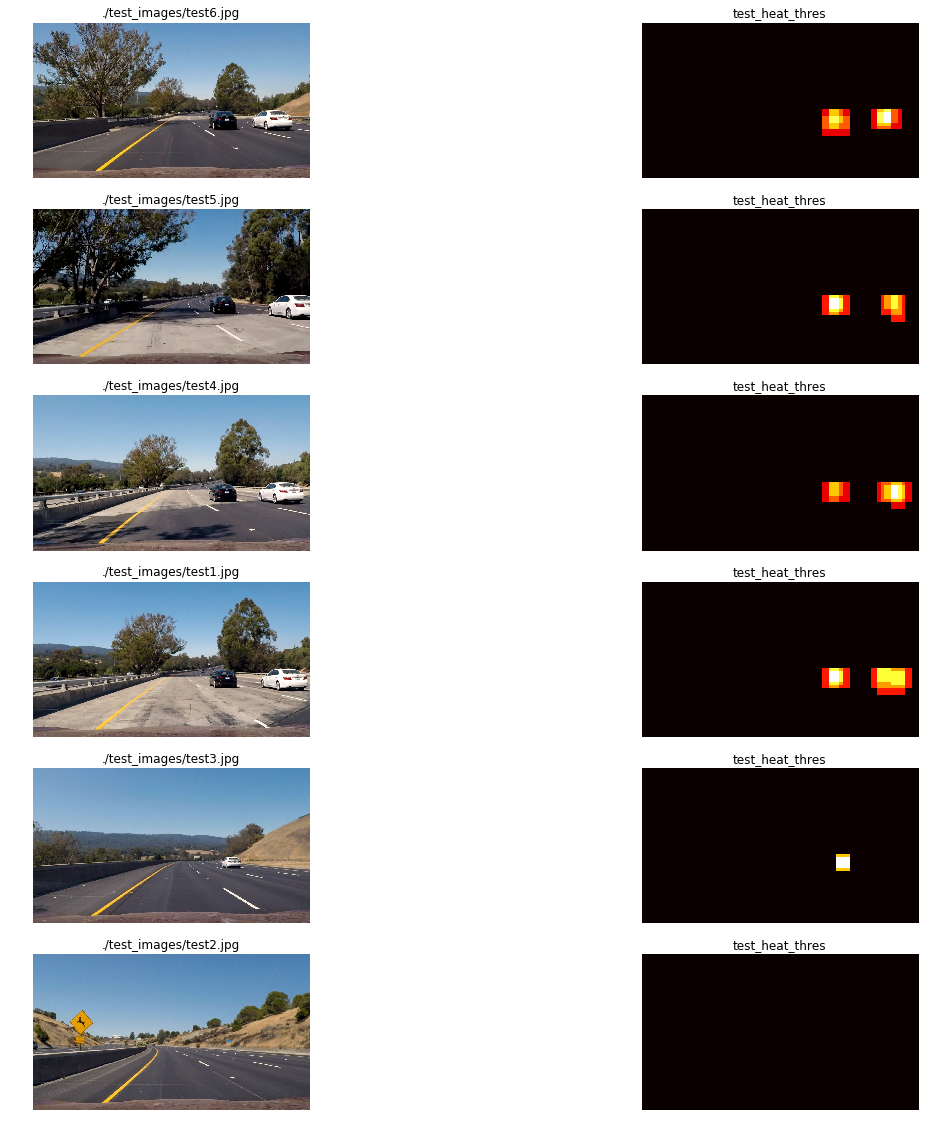

In [204]:
# show thresholded heat map
showImagesSidebySide(testImages, heatThreImages, "test", "test_heat_thres", testImagesName, cmap='hot')


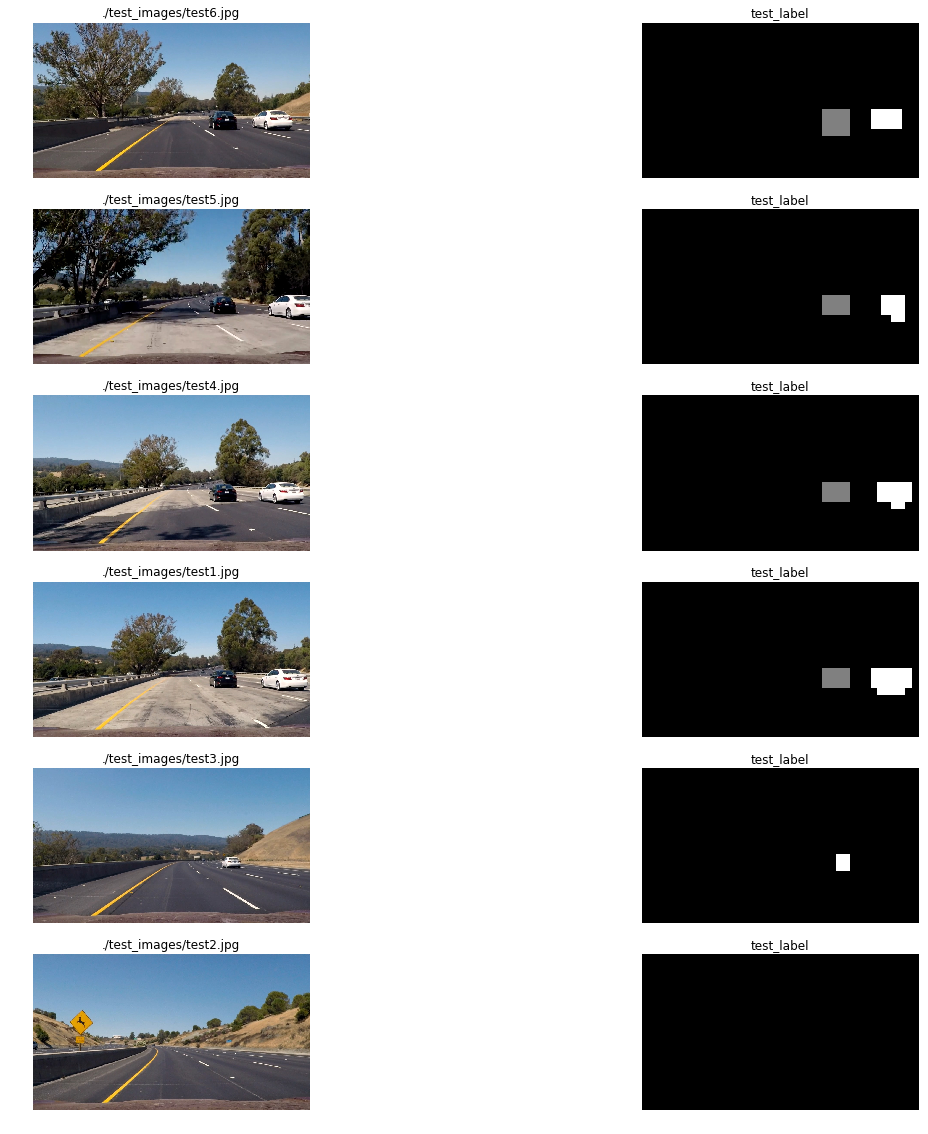

In [207]:
showImagesSidebySide(testImages, labelImages, "test", "test_label", testImagesName,cmap='gray')


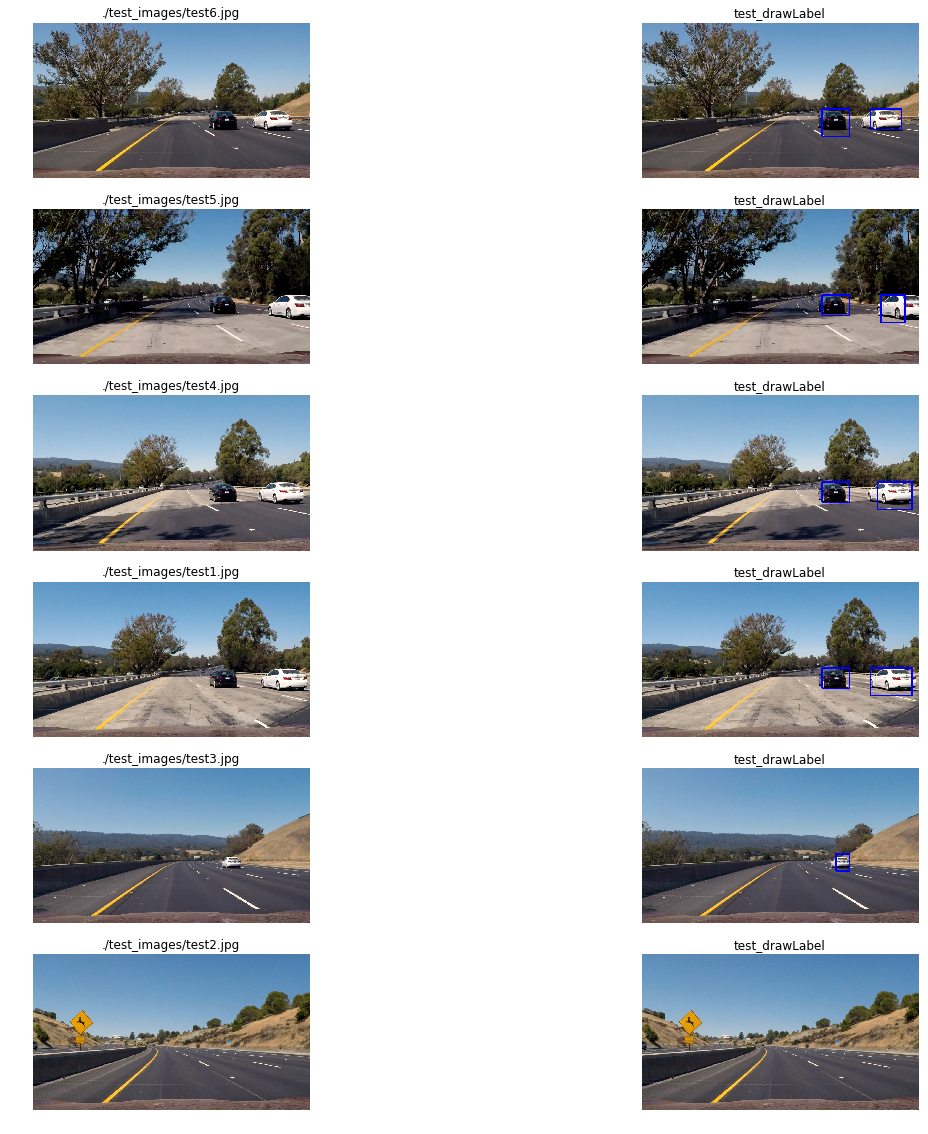

In [208]:
showImagesSidebySide(testImages, drawLabelImages, "test", "test_drawLabel", testImagesName)

### Run a Video Through the Pipeline (primitive version)
This only processes a frame at a time without accounting for information from previous frames

In [209]:
def pipeline(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    rectangles = detectInSlideWin(img, colorspace, orient, 
                              pix_per_cell, cell_per_block, hog_channel)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img 

print('...')

...


In [210]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  4.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 8.43 s, sys: 1.01 s, total: 9.45 s
Wall time: 9.86 s


In [211]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

### Define a Class to Store Data from Vehicle Detections

In [131]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self, maxFrames):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        self.max_frames = maxFrames
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > self.max_frames:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-self.max_frames:]

print('...')

...


### Pipeline for Processing Video Frames

In [150]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    

    rectangles = detectInSlideWin(img, colorspace, orient, 
                              pix_per_cell, cell_per_block, hog_channel) 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    # filter and remove the false position
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


### Run a Video Through the Pipeline (advanced version)
This processes each frame while accounting for information from previous frames

In [151]:
det = Vehicle_Detect(10)

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:08<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 8.3 s, sys: 850 ms, total: 9.15 s
Wall time: 9.6 s


In [152]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [154]:
det = Vehicle_Detect(10)

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:52<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 4min 34s, sys: 27.2 s, total: 5min 1s
Wall time: 4min 53s


In [104]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))